In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
import seaborn as sns
sns.set_style("white")

# Parameters of the plots
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [2]:
def importances(model, col_array, title): 
    # Calculate the feature ranking - Top 10 
    importances = model.feature_importances_ 
    indices = np.argsort(importances)[::-1]
    print("Top Important Features\n", title)
    #for f in range(col_array.shape[1]-1): 
    for f in range(10): 
        print("%d. %s (%f)" % (f + 1, col_array.columns[indices[f]], importances[indices[f]]))
        
    #Mean Feature Importance 
    print("\nMean Feature Importance ", np.mean(importances))
    #Plot the feature importances of the forest 
    indices=indices[:10]
    plt.figure()
    plt.title(title+" Top 10 Feature importances")
    plt.bar(range(10), importances[indices], color="gr", align="center")
    plt.xticks(range(10), col_array.columns[indices], fontsize=8, rotation=90)
    plt.xlim([-1, 10])
    plt.show()

# 1. Original spatial distribution of stations and messages 

In [3]:
# Load train and test data
X_train = pd.read_csv('my_train_merged.csv') # train set
X_test = pd.read_csv('my_test_merged.csv') # test set

y_train = X_train.iloc[:, -2:]
X_train = X_train.drop(columns=['lat', 'lng'])

y_test = X_test.iloc[:, -2:]
X_test = X_test.drop(columns=['lat', 'lng'])

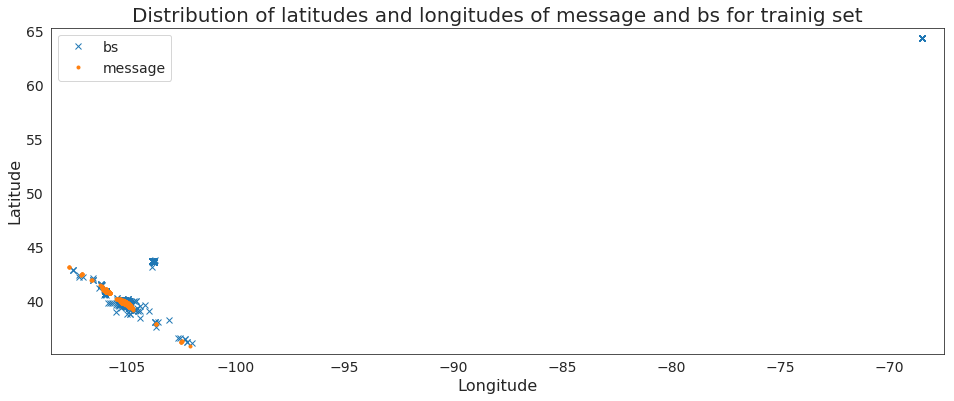

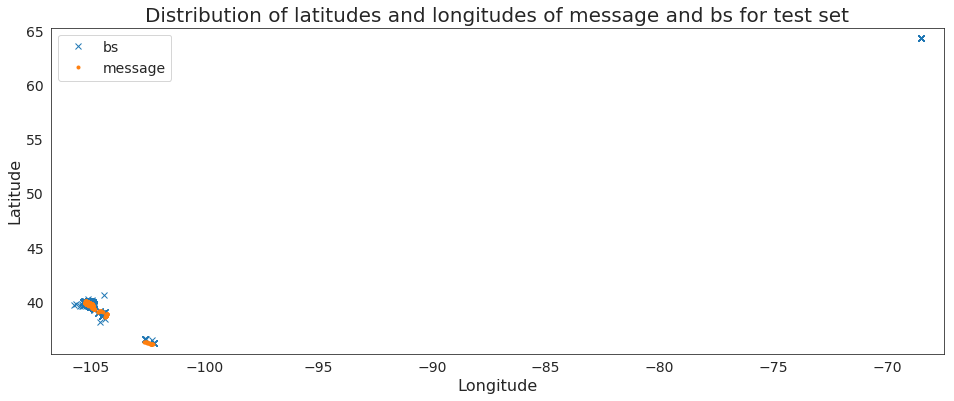

In [4]:
# Plotting latitudes and longitudes of bs and messages for training and test sets
plt.figure(figsize=(16,6))
plt.plot(X_train['bs_lng'], X_train['bs_lat'], 'x', label='bs')
plt.plot(y_train['lng'], y_train['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.xlim(X_train['bs_lng'].min()-1, X_train['bs_lng'].max()+1)
plt.ylim(X_train['bs_lat'].min()-1, X_train['bs_lat'].max()+1)
plt.title('Distribution of latitudes and longitudes of message and bs for trainig set')
plt.legend()

plt.figure(figsize=(16,6))
plt.plot(X_test['bs_lng'], X_test['bs_lat'], 'x', label='bs')
plt.plot(y_test['lng'], y_test['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.xlim(X_test['bs_lng'].min()-1, X_test['bs_lng'].max()+1)
plt.ylim(X_test['bs_lat'].min()-1, X_test['bs_lat'].max()+1)
plt.title('Distribution of latitudes and longitudes of message and bs for test set')
plt.legend()


# 2. Analysis of distance between stations and messages

In [5]:
# Functions to compute distances

# Option 1
def calc_distance_bs_message(X, pos):
    df = X.join(pos)
    
    mess_lat = df['lat'] * np.pi / 180
    bs_lat = df['bs_lat'] * np.pi / 180
    mess_lng = df['lng'] * np.pi / 180
    bs_lng = df['bs_lng'] * np.pi / 180

    dlon = bs_lng - mess_lng
    dlat = bs_lat - mess_lat
    R = 6373
    a = (np.sin(dlat/2))**2 + np.cos(mess_lat) * np.cos(bs_lat) * (np.sin(dlon/2))**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c    
    
    return distance

# Option 2
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

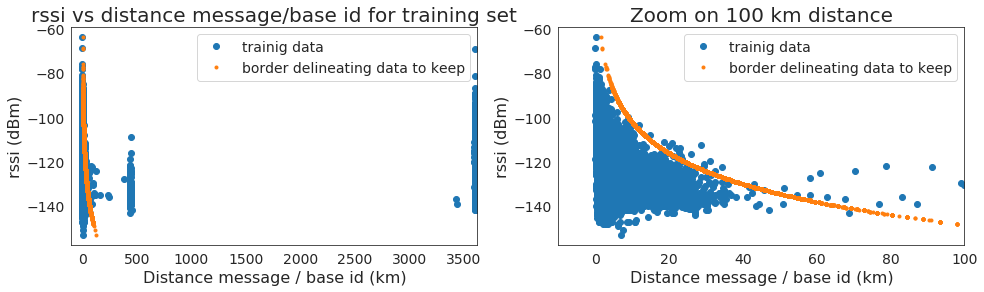

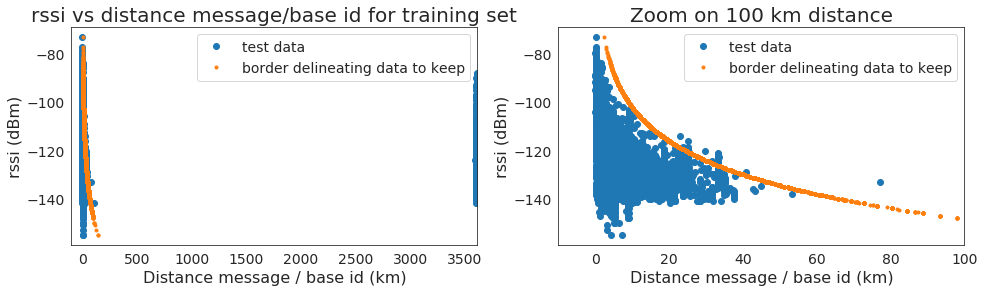

In [6]:
# Defining distances of datasets and distances to keep (option 1)
X_train['distance'] = calc_distance_bs_message(X_train, y_train)
X_test['distance'] = calc_distance_bs_message(X_test, y_test)

## Defining distances of datasets and distances to keep (option 2)
#df = X_train.join(y_train)
#X_train['distance'] = vincenty_vec(df[['bs_lat', 'bs_lng', 'lat', 'lng']].values)
#X_train['distance'] /= 1000
#df = X_test.join(y_test)
#X_test['distance'] = vincenty_vec(df[['bs_lat', 'bs_lng', 'lat', 'lng']].values)
#X_test['distance'] /= 1000

d_keep_train = np.exp(- X_train['rssi'] / 20) * 0.06
d_keep_test = np.exp(- X_test['rssi'] / 20) * 0.06

# Plotting distances and rssi of bs and messages for training set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(X_train['distance'], X_train['rssi'], 'o', label='trainig data')
plt.plot(d_keep_train, X_train['rssi'],'.', label='border delineating data to keep')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt.xlim(-100, X_train['distance'].max())
plt. title('rssi vs distance message/base id for training set')
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_train['distance'], X_train['rssi'], 'o', label='trainig data')
plt.plot(d_keep_train, X_train['rssi'],'.', label='border delineating data to keep')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('Zoom on 100 km distance')
plt.xlim(-10,100)
plt.legend()

# Plotting distances and rssi of bs and messages for test set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(X_test['distance'], X_test['rssi'], 'o', label='test data')
plt.plot(d_keep_test, X_test['rssi'],'.', label='border delineating data to keep')
plt.xlim(-100, X_test['distance'].max())
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('rssi vs distance message/base id for training set')
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_test['distance'], X_test['rssi'], 'o', label='test data')
plt.plot(d_keep_test, X_test['rssi'],'.', label='border delineating data to keep')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('Zoom on 100 km distance')
plt.xlim(-10,100)
plt.legend()

# 3. Correction of misplaced stations 

In [7]:
# Function to correct bs_lat, bs_lng and distances in dataframes
def correct_lat_lng_misplaced_bs(X, y, d_keep):
    
    # Define dataframes
    df = X.join(y)
    df['mul'] = 0
    df['mul'] = df['mul'].where(df['distance'] > d_keep, 1)

    df_1 = df.copy()
    df_1 = df_1.loc[df_1['mul'] != 0]
    df_2 = df.copy()
    df_2 = df_2.loc[df_2['mul'] == 0]

    X_train = df_1.copy()
    X_test = df_2.copy()
    col = ['rssi', 'time_ux','nseq','lat', 'lng']
    X_train = X_train[col]
    X_test = X_test[col]
    ground_truth_lat = df_1['bs_lat']
    ground_truth_lng = df_1['bs_lng']
    
    # Fit non linear regression
    clr = RandomForestRegressor(n_estimators=100)
    clr.fit(X_train, ground_truth_lat)
    y_pred_lat = clr.predict(X_test)

    clr.fit(X_train, ground_truth_lng)
    y_pred_lng = clr.predict(X_test)
    
    df_2['bs_lat'] = df_2['bs_lat'] * df_2['mul'] + y_pred_lat
    df_2['bs_lng'] = df_2['bs_lng'] * df_2['mul'] + y_pred_lng

    # Prepare final result with computation of distances
    result = pd.concat([df_1, df_2])
    result = result.drop(columns=['mul','distance'])
    result['distance'] = calc_distance_bs_message(result.iloc[:, :-2], result.iloc[:, -2:])
    result['d_keep'] = d_keep
    #result = result.drop(columns=['lat', 'lng'])
    return result.drop(columns=['lat', 'lng']), result[['lat', 'lng']]

In [8]:
# Corrected data
X_train_c, y_train_c = correct_lat_lng_misplaced_bs(X_train, y_train, d_keep_train)
X_test_c, y_test_c = correct_lat_lng_misplaced_bs(X_test, y_test, d_keep_test)

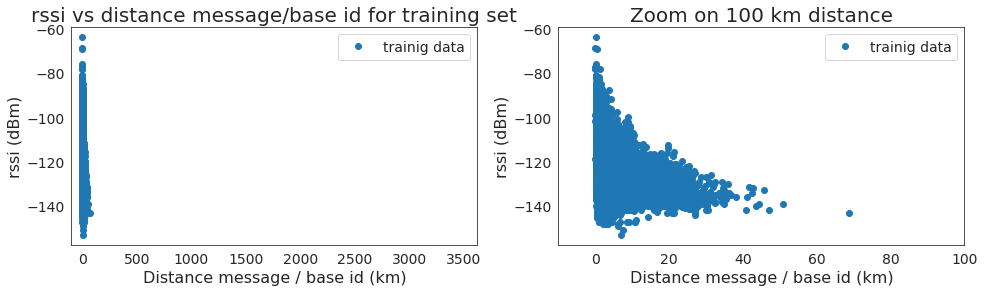

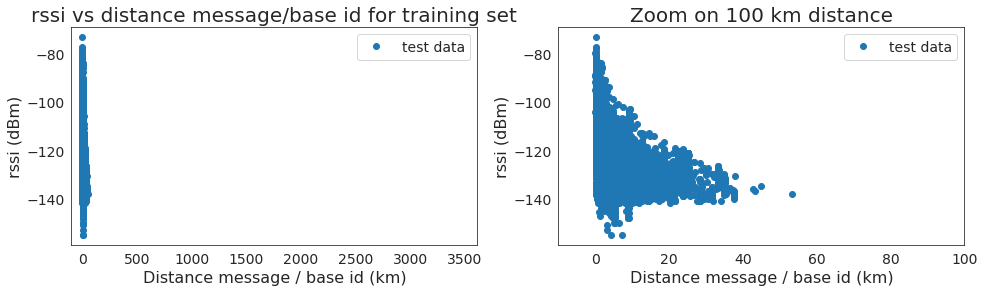

In [9]:
# Plotting distances and rssi of bs and messages for corrected training set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(X_train_c['distance'], X_train_c['rssi'], 'o', label='trainig data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('rssi vs distance message/base id for training set')
plt.xlim(-100, X_train['distance'].max())
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_train_c['distance'], X_train_c['rssi'], 'o', label='trainig data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('Zoom on 100 km distance')
plt.xlim(-10,100)
plt.legend()

# Plotting distances and rssi of bs and messages for corrected test set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(X_test_c['distance'], X_test_c['rssi'], 'o', label='test data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('rssi vs distance message/base id for training set')
plt.xlim(-100, X_test['distance'].max())
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_test_c['distance'], X_test_c['rssi'], 'o', label='test data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('Zoom on 100 km distance')
plt.xlim(-10,100)
plt.legend()

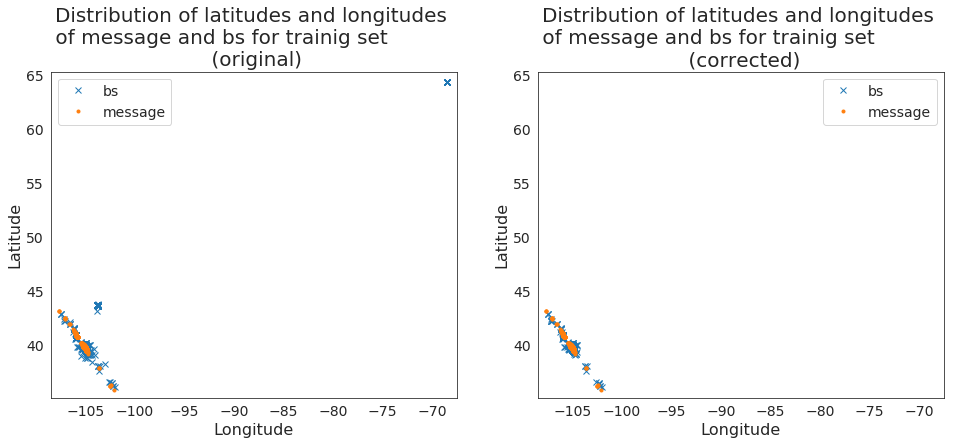

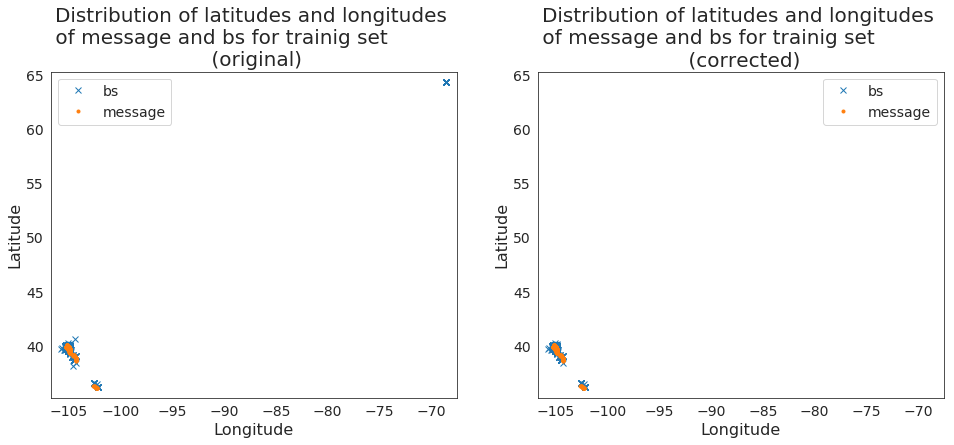

In [10]:
# Plotting latitudes and longitudes of bs and messages for training and test sets
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(X_train['bs_lng'], X_train['bs_lat'], 'x', label='bs')
plt.plot(y_train['lng'], y_train['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.xlim(X_train['bs_lng'].min()-1, X_train['bs_lng'].max()+1)
plt.ylim(X_train['bs_lat'].min()-1, X_train['bs_lat'].max()+1)
plt.title('Distribution of latitudes and longitudes \n of message and bs for trainig set \
          \n (original)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_train_c['bs_lng'], X_train_c['bs_lat'], 'x', label='bs')
plt.plot(y_train_c['lng'], y_train_c['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.xlim(X_train['bs_lng'].min()-1, X_train['bs_lng'].max()+1)
plt.ylim(X_train['bs_lat'].min()-1, X_train['bs_lat'].max()+1)
plt.title('Distribution of latitudes and longitudes \n of message and bs for trainig set \
          \n (corrected)')
plt.legend()

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(X_test['bs_lng'], X_test['bs_lat'], 'x', label='bs')
plt.plot(y_test['lng'], y_test['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.xlim(X_test['bs_lng'].min()-1, X_test['bs_lng'].max()+1)
plt.ylim(X_test['bs_lat'].min()-1, X_test['bs_lat'].max()+1)
plt.title('Distribution of latitudes and longitudes \n of message and bs for trainig set \
          \n (original)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_test_c['bs_lng'], X_test_c['bs_lat'], 'x', label='bs')
plt.plot(y_test_c['lng'], y_test_c['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.xlim(X_test['bs_lng'].min()-1, X_test['bs_lng'].max()+1)
plt.ylim(X_test['bs_lat'].min()-1, X_test['bs_lat'].max()+1)
plt.title('Distribution of latitudes and longitudes \n of message and bs for trainig set \
          \n (corrected)')
plt.legend()

# 4. Predictions

## Feature matrix and ground truth

In [11]:
listOfBs = np.union1d(np.unique(X_train_c['bsid']), np.unique(X_test_c['bsid'])) # determine all Base stations that received at least 1 message

In [12]:
# Feature Matrix construction 

def feat_mat_const(df_mess_train, listOfBs):
    lat_listOfBs = ['lat_' + s for s in list(listOfBs.astype(str))]
    lng_listOfBs = ['lng_' + s for s in list(listOfBs.astype(str))]
    nseq_listOfBs = ['nseq_' + s for s in list(listOfBs.astype(str))]
    timeux_listOfBs = ['timeux_' + s for s in list(listOfBs.astype(str))]
    dist_listOfBs = ['dist_' + s for s in list(listOfBs.astype(str))]
    dkeep_listOfBs = ['dkeep_' + s for s in list(listOfBs.astype(str))]
    feature_cols = list(listOfBs.astype(str)) + lat_listOfBs + lng_listOfBs \
                    + nseq_listOfBs + dist_listOfBs + dkeep_listOfBs + timeux_listOfBs
    
    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(feature_cols))), columns = feature_cols) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:  
        #print(key)
        df_mess_bs_group.get_group(key)
        bsid_list = df_mess_bs_group.get_group(key)['bsid'].astype(str)
        lat_bsid_list = ['lat_' + s for s in list(bsid_list.astype(str))]
        lng_bsid_list = ['lng_' + s for s in list(bsid_list.astype(str))]
        nseq_bsid_list = ['nseq_' + s for s in list(bsid_list.astype(str))]
        dist_bsid_list = ['dist_' + s for s in list(bsid_list.astype(str))]
        dkeep_bsid_list = ['dkeep_' + s for s in list(bsid_list.astype(str))]
        timeux_bsid_list = ['timeux_' + s for s in list(bsid_list.astype(str))]        
        rssi_list = df_mess_bs_group.get_group(key)['rssi']
        bs_lat_list = df_mess_bs_group.get_group(key)['bs_lat']
        bs_lng_list = df_mess_bs_group.get_group(key)['bs_lng']
        nseq_list = df_mess_bs_group.get_group(key)['nseq']
        dist_list = df_mess_bs_group.get_group(key)['distance']
        dkeep_list = df_mess_bs_group.get_group(key)['d_keep']
        timeux_list = df_mess_bs_group.get_group(key)['time_ux']
        df_feat.loc[idx, bsid_list] = rssi_list.values
        df_feat.loc[idx, lat_bsid_list] = bs_lat_list.values
        df_feat.loc[idx, lng_bsid_list] = bs_lng_list.values
        df_feat.loc[idx, nseq_bsid_list] = nseq_list.values
        df_feat.loc[idx, dist_bsid_list] = dist_list.values        
        df_feat.loc[idx, dkeep_bsid_list] = dkeep_list.values        
        df_feat.loc[idx, timeux_bsid_list] = timeux_list.values        
        
        id_list[idx] = key
        idx = idx + 1
    
    #df_feat['count'] = df_count_messid['count']
    return df_feat, id_list # add id value of each message for the correspondance to message

In [13]:
# Generate train features matrix
df_feat, id_list_train = feat_mat_const(X_train_c, listOfBs)
df_feat.head()

,879,911,921,944,980,1012,1086,1092,1120,1148,...,timeux_8747,timeux_9784,timeux_9899,timeux_10134,timeux_10148,timeux_10151,timeux_10162,timeux_10999,timeux_11007,timeux_11951
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
len(listOfBs) * 7 # 7 set of features

1757

In [15]:
# Generate train features matrix
df_feat_test, id_list_test = feat_mat_const(X_test_c, listOfBs)
df_feat_test.head()

,879,911,921,944,980,1012,1086,1092,1120,1148,...,timeux_8747,timeux_9784,timeux_9899,timeux_10134,timeux_10148,timeux_10151,timeux_10162,timeux_10999,timeux_11007,timeux_11951
0,0.0,0.0,0.0,0.0,0.0,0.0,-141.0,0.0,0.0,0.0,...,0.0,0.0,1.463586e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [17]:
gr_truth_lat_train, gr_truth_lng_train = ground_truth_const(X_train_c, y_train_c)

In [18]:
gr_truth_lat_train.shape

(4418,)

In [19]:
len(np.unique(X_train_c['messid']))

4418

In [20]:
gr_truth_lat_test, gr_truth_lng_test = ground_truth_const(X_test_c, y_test_c)
gr_truth_lat_test.shape

(1650,)

In [21]:
len(np.unique(X_test_c['messid']))

1650

## Model and prediction

In [22]:
def regressor_and_predict(df_feat, gr_truth_lat_train, gr_truth_lng_train, df_test, gr_truth_lat_test, gr_truth_lng_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat, ground_truth_lat, ground_truth_lng, df_test
    # Output: y_pred_lat, y_pred_lng

    from sklearn import linear_model

    X_train = np.array(df_feat);
    X_test = np.array(df_test);
    #reg = linear_model.LinearRegression()
    #reg = RandomForestRegressor(random_state=2792)
    reg = ExtraTreesRegressor()

    reg.fit(X_train, gr_truth_lat_train);
    y_pred_lat = reg.predict(df_test) 
    print("Latitude Accuracy :", reg.score(X_test, gr_truth_lat_test))
    importances(reg, df_feat, "Latitude Features utilisée")

    reg.fit(X_train, gr_truth_lng_train);
    y_pred_lng = reg.predict(df_test) 
    print("Longitude Accuracy :", reg.score(X_test, gr_truth_lng_test))
    importances(reg, df_feat, "Longitude Features utilisée")
    
    return y_pred_lat, y_pred_lng

Latitude Accuracy : 0.35828174594609263
Top Important Features
 Latitude Features utilisée
1. timeux_4790 (0.185866)
2. lng_4790 (0.185858)
3. 4790 (0.123943)
4. lat_4790 (0.123902)
5. 3613 (0.043982)
6. 1828 (0.030419)
7. lng_3613 (0.029312)
8. lng_1828 (0.012168)
9. lng_2831 (0.011201)
10. lng_7807 (0.010545)

Mean Feature Importance  0.0005691519635742744


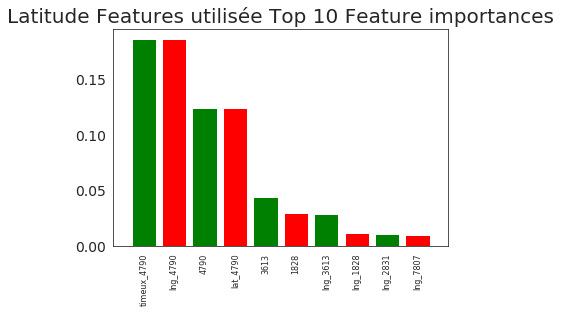

Longitude Accuracy : 0.25589614540522887
Top Important Features
 Longitude Features utilisée
1. lng_4790 (0.256406)
2. timeux_4790 (0.128219)
3. lat_4790 (0.128210)
4. 4790 (0.064295)
5. dkeep_4790 (0.064241)
6. timeux_3613 (0.029543)
7. 1828 (0.028203)
8. lng_1828 (0.028203)
9. lat_3613 (0.022153)
10. lng_2831 (0.017730)

Mean Feature Importance  0.0005691519635742742


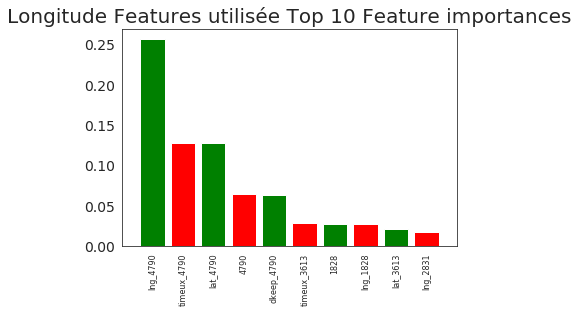

In [23]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, gr_truth_lat_train, gr_truth_lng_train, 
                                               df_feat_test, gr_truth_lat_test, gr_truth_lng_test)

## Prediction on training
#y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, gr_truth_lat_train, gr_truth_lng_train, 
#                                               df_feat, gr_truth_lat_train, gr_truth_lng_train)

## Error evaluation on test set

In [24]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [25]:
err_vec = Eval_geoloc(gr_truth_lat_test , gr_truth_lng_test, y_pred_lat, y_pred_lng)

## Error on training
#err_vec = Eval_geoloc(gr_truth_lat_train , gr_truth_lng_train, y_pred_lat, y_pred_lng)

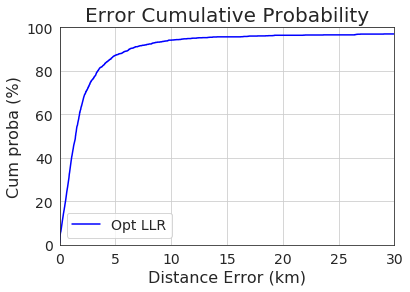

In [26]:
# Plot error distribution
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

In [27]:
# Error criterion
np.percentile(err_vec, 80)

3433.80744172251

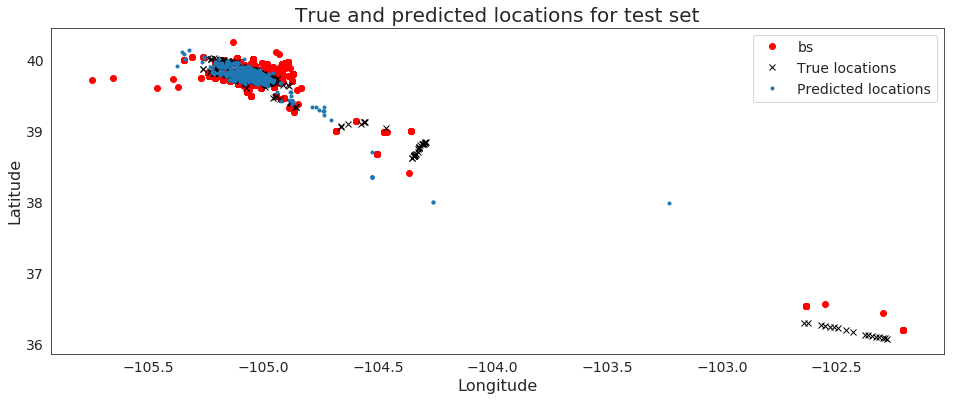

In [31]:
# Plot of true and predicted locations for test set
plt.figure(figsize=(16,6))
plt.plot(X_test_c['bs_lng'], X_test_c['bs_lat'], 'ro', label='bs')
plt.plot(gr_truth_lng_test, gr_truth_lat_test, 'kx', label='True locations')
plt.plot(y_pred_lng, y_pred_lat, '.', label='Predicted locations')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.title('True and predicted locations for test set')
plt.legend()